In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip install wfdb

     |████████████████████████████████| 102kB 4.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/bb/a9/00/0078d26b0c15b31be0001af8eb659496709c361c69641303f1
Successfully built wfdb


In [0]:
import wfdb

base_dir = '/content/drive/My Drive/STUDIA/SEM 8/adne/'
record = wfdb.rdrecord(base_dir + 'I01') 

In [5]:
record.p_signal.shape

(462600, 12)

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow.python.keras import layers
import matplotlib.pyplot as plt

Use one ECG record alredy converted to 'npy' format and using sampling rate=125 Hz

ECG shape:  (2, 462600)


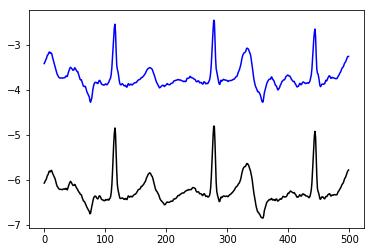

In [28]:
#ecg = np.load(base_dir + 'sel116.npy')
ecg = np.transpose(record.p_signal)
ecg = ecg[8:10, :]
ecg=ecg.astype(np.float32)
print('ECG shape: ', ecg.shape)
t = range(500)
plt.plot(t,ecg[0,t],'b',t,ecg[1,t]-2,'k')
plt.show()

# Task:
We want to create network that receives a segment of the first ecg channel (blue) and returns the corresponding segment of the second channel (black). The segment length must be fixed.






In [0]:
# auxiliary function
# extracts from a long np-array (2-rows) a (2-rows)-random segment with a fixed length (seqL*ninputs)
def selectFrom1ecg(ecgBdata,seqL, ninputs):
    """ecgBdata.shape=(1,112500) 
    seqL:  number of timesteps to be used in recurrent nn
    ninput : is number of inputs in each timestep
    """
    segmentL  = seqL * ninputs
    numChan = 2
    inpOutSegment = tf.random_crop(ecgBdata,[numChan, segmentL])
    inputs = inpOutSegment[0,:]
    target = inpOutSegment[1,:]
    return inputs,target


Let's divide the ECG data in three parts: first part for training, second for validation and last and last part for testing.

A tensorflow 'Dataset' can be used to represent an input pipeline as a collection of elements (nested structures of tensors) and a "logical plan" of transformations that act on those elements.

In [0]:
N = ecg.shape[1]
seqL = 20
fs = 125
ninputs = int(0.2*fs)

# training data
trainData =tf.data.Dataset.from_tensors(ecg[:,:N-10000])
trainData = trainData.map(lambda x:  selectFrom1ecg(x,seqL, ninputs))
trainData = trainData.repeat()  # Repeat the input indefinitely.
batchSize = 8
trainData = trainData.batch(batchSize)

# validation data
valData =tf.data.Dataset.from_tensors(ecg[:,N-10000:N-5000])
valData = valData.map(lambda x:  selectFrom1ecg(x,seqL, ninputs))
valData = valData.repeat()  # Repeat the input indefinitely.
batchSize = 8
valData = valData.batch(batchSize)

# test data
testData =tf.data.Dataset.from_tensors(ecg[:,N-5000:])
testData = testData.map(lambda x:  selectFrom1ecg(x,seqL, ninputs))
testData = testData.repeat()  # Repeat the input indefinitely.
batchSize = 8
testData = testData.batch(batchSize)

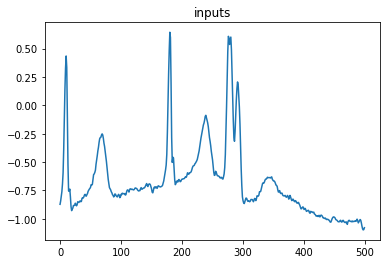

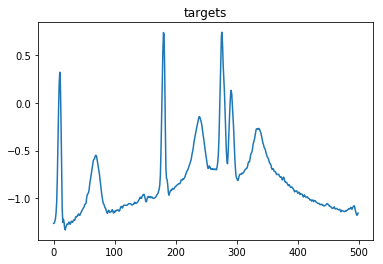

In [30]:
# let's visualize the model's input data and target data
iterator = trainData.make_initializable_iterator()
next_element = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    inp, targ = sess.run(next_element)
plt.plot(inp[0,:])
plt.title('inputs')
plt.show()
plt.plot(targ[0,:])
plt.title('targets')
plt.show()

# MLP model


In [31]:
ffwdModel = tf.keras.Sequential()
ffwdModel.add(layers.Dense(64, activation='relu',input_shape=(seqL*ninputs,)))
ffwdModel.add(layers.Dense(64, activation='relu'))
ffwdModel.add(layers.Dense(seqL*ninputs))

ffwdModel.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
ffwdModel.fit(trainData,  epochs=10, steps_per_epoch=1000, validation_data=valData, validation_steps=100)

Epoch 1/10
1000/1000 [==============================] - 3s 3ms/step - loss: 1.7314 - mean_absolute_error: 1.0597 - val_loss: 0.7151 - val_mean_absolute_error: 0.7525
Epoch 2/10
1000/1000 [==============================] - 3s 3ms/step - loss: 1.5009 - mean_absolute_error: 1.0009 - val_loss: 0.6259 - val_mean_absolute_error: 0.7015
Epoch 3/10
1000/1000 [==============================] - 3s 3ms/step - loss: 1.4460 - mean_absolute_error: 0.9823 - val_loss: 0.9148 - val_mean_absolute_error: 0.8629
Epoch 4/10
1000/1000 [==============================] - 3s 3ms/step - loss: 1.4482 - mean_absolute_error: 0.9759 - val_loss: 0.8654 - val_mean_absolute_error: 0.8206
Epoch 5/10
1000/1000 [==============================] - 3s 3ms/step - loss: 1.4873 - mean_absolute_error: 0.9898 - val_loss: 0.7657 - val_mean_absolute_error: 0.7724
Epoch 6/10
1000/1000 [==============================] - 3s 3ms/step - loss: 1.4811 - mean_absolute_error: 0.9856 - val_loss: 0.8575 - val_mean_absolute_error: 0.8153
Epoc

500/500 [==============================] - 1s 2ms/step - loss: 2.0163 - mean_absolute_error: 1.3286
test mean square error (loss):  2.0162873891592024   test absolute error:  1.328617


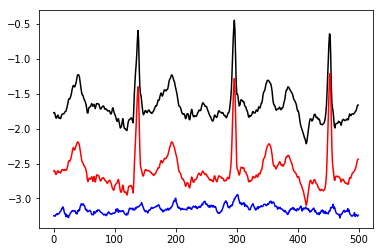

In [32]:
out = ffwdModel.evaluate(testData, steps=500)
print('test mean square error (loss): ', out[0], '  test absolute error: ', out[1])
iterator = trainData.make_initializable_iterator()
next_element = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    inp, targ = sess.run(next_element)
output = ffwdModel.predict(inp)
t = range(seqL*ninputs)
plt.plot(t,inp[0,:],'k',t,targ[0]-2,'r',t,output[0]-2,'b')
plt.show()

# Recurrent model


In [33]:
numLstmUnits = 32
denseDim = ninputs
rnnModel = tf.keras.Sequential()
rnnModel.add(layers.Reshape((seqL,ninputs), input_shape=(seqL*ninputs,)))
rnnModel.add(layers.CuDNNLSTM(units=numLstmUnits, return_sequences=True))         
rnnModel.add(layers.CuDNNLSTM(units=numLstmUnits, return_sequences=True))
rnnModel.add(layers.TimeDistributed(layers.Dense(denseDim)))
rnnModel.add(layers.Reshape((seqL*ninputs,)))

rnnModel.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
rnnModel.fit(trainData,  epochs=10, steps_per_epoch=1000, validation_data=valData, validation_steps=100)

Epoch 1/10
1000/1000 [==============================] - 9s 9ms/step - loss: 1.6674 - mean_absolute_error: 1.0128 - val_loss: 0.6881 - val_mean_absolute_error: 0.7204
Epoch 2/10
1000/1000 [==============================] - 5s 5ms/step - loss: 1.2435 - mean_absolute_error: 0.8876 - val_loss: 0.4522 - val_mean_absolute_error: 0.5597
Epoch 3/10
1000/1000 [==============================] - 5s 5ms/step - loss: 1.2254 - mean_absolute_error: 0.8798 - val_loss: 0.4305 - val_mean_absolute_error: 0.5413
Epoch 4/10
1000/1000 [==============================] - 5s 5ms/step - loss: 1.2229 - mean_absolute_error: 0.8810 - val_loss: 0.6060 - val_mean_absolute_error: 0.6393
Epoch 5/10
1000/1000 [==============================] - 5s 5ms/step - loss: 1.1959 - mean_absolute_error: 0.8631 - val_loss: 0.5702 - val_mean_absolute_error: 0.6238
Epoch 6/10
1000/1000 [==============================] - 5s 5ms/step - loss: 1.2015 - mean_absolute_error: 0.8721 - val_loss: 0.6316 - val_mean_absolute_error: 0.6585
Epoc

500/500 [==============================] - 2s 3ms/step - loss: 1.5150 - mean_absolute_error: 1.1488
test mean square error (loss):  1.5150318635702134   test absolute error:  1.1487513


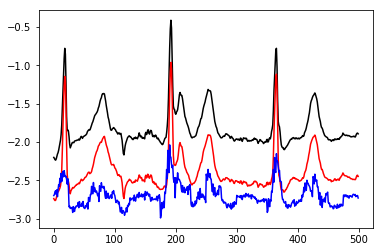

In [34]:
rnnModel.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
out = rnnModel.evaluate(testData, steps=500)
print('test mean square error (loss): ', out[0], '  test absolute error: ', out[1])
iterator = trainData.make_initializable_iterator()
next_element = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    inp, targ = sess.run(next_element)
output = rnnModel.predict(inp)
t = range(seqL*ninputs)
plt.plot(t,inp[0,:],'k',t,targ[0]-2,'r',t,output[0]-2,'b')
plt.show()